In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [3]:
import torch

# Données synthétiques

In [5]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [233]:
import itertools
mu = 1.0
tmax = 20.0
alpha = 0.4
beta  = 1.5

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 33.333


In [234]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

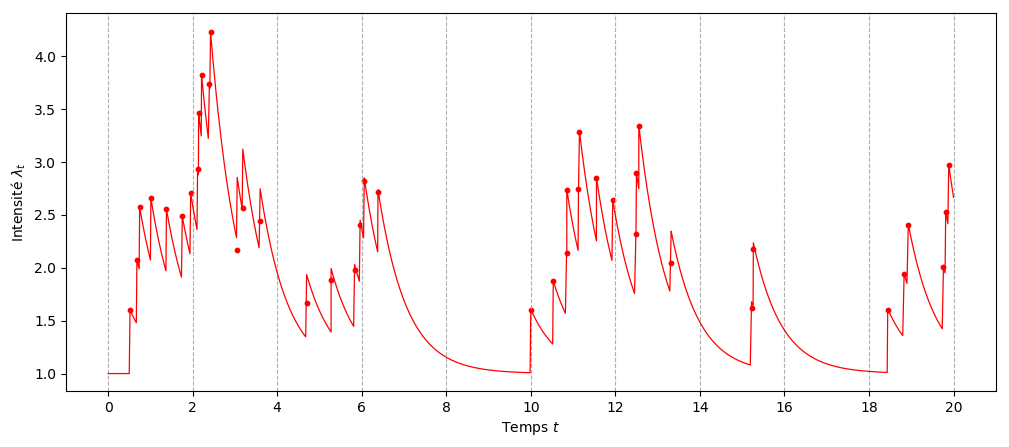

In [235]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [236]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])+1
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
data_array = np.stack([
    np.pad(s[:,0], ((0, input_size - s.shape[0] - 1)), 'constant') for s in sample_trajectories
])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

# Add a beginning-of-sequence event:
data_tensor = torch.cat((torch.zeros(data_tensor.shape[0],1), data_tensor), dim=1)

Number of samples: 		400
Input size max. traj. length: 	65
tmax = 20.000


In [237]:
data_tensor.shape

torch.Size([400, 65])

The first dimension is for time, the second for the sample.

## Neural net

In [238]:
import torch
import torch.nn as nn
from torch import optim

In [239]:
device = torch.device("cpu")
print(device)

cpu


In [240]:
torch.manual_seed(1)

The intensity process is given by
$$
    \lambda_k(t) = f_k(\mathbf w_\alpha\mathbf h(t) + \mathbf b_\alpha)
$$
with $\mathbf h(t)$ the hidden state, defined from the cell state $\mathbf c(t)$ :
$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i].
$$

with
$$
    \mathbf c(t) = \bar{\mathbf c}_{i+1} + (\mathbf c_{i+1} - \bar{\mathbf c}_{i+1})\exp\left(-\delta_{i+1}(t-t_i)\right),\quad t\in(t_{i-1}, t_i].
$$

In [241]:
from models import NeuralCTLSTM
import tqdm

In [242]:
# We use mini-batches to train on our data
BATCH_SIZE = 40
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

hidden_size = 8
learn_rate = 0.0008

nhlstm = NeuralCTLSTM(hidden_size)
optimizer = optim.SGD(nhlstm.parameters(), lr=learn_rate)

Batch size: 40
Training sample size: 400
Splitting into batches of 40
No. of batches: 10


In [243]:
def train(event_times, input_size):
    """Train on input sequence
    
    Args:
        event_times: input sequence
    """
    dt = event_times[1:] - event_times[:-1]
    # event_times = split_into_batches[i]
    # inter_t = event_times[:,:-1] - event_times[:,1:] # transform into inter-arrival times
    # batch_size = inter_t.size(0)
    output_hist = []
    hidden_hist = []
    cell_hist = []
    cell_target_hist = []
    decay_hist = []
    # Initialize hidden and cell state at 0
    hidden, cti, cbar = nhlstm.init_hidden()
    # Reset gradients; in PyTorch they accumulate
    nhlstm.zero_grad()
    # Loop over event times
    # First pass takes care of the interval [0,t1) before first event
    for j in range(input_size - 1):
        output, hidden, cti, cell_t, cbar, decay_t = nhlstm(dt[j], hidden, cti, cbar)
        output_hist.append(output)
        hidden_hist.append(hidden)
        cell_hist.append(cti)
        cell_target_hist.append(cbar)
        decay_hist.append(decay_t)
    output_hist = torch.stack(output_hist, dim=1)
    hidden_hist = torch.stack(hidden_hist, dim=1)
    cell_hist = torch.stack(cell_hist, dim=1)
    cell_target_hist = torch.stack(cell_target_hist, dim=1)
    decay_hist = torch.stack(decay_hist, dim=1)
    loss = nhlstm.likelihood(
        event_times, seq_lengths[i], cell_hist, cell_target_hist,
        output_hist, decay_hist, tmax)
    # Compute the gradients
    loss.backward()
    # Update the model parameters
    optimizer.step()
    hist_dict = dict(
        output=output_hist,
        hidden=hidden_hist,
        cell_state=cell_hist,
        cell_target=cell_target_hist,
        decay=decay_hist
    )
    return loss, hist_dict

In [244]:
# batch_range = tqdm.trange(num_of_batches)
# batch_range = tqdm.trange(data_tensor.size(0))
train_size = 400
batch_range = tqdm.tqdm_notebook(range(train_size))
loss_hist = []
for i in batch_range:
    batch_range.set_description("Batch %d" % (i+1))
    # sample's event times
    event_times = data_tensor[i]
    loss, hists_ = train(event_times, input_size)
    loss_val = loss.item()
    batch_range.set_postfix(loss=loss_val)
    loss_hist.append(loss_val) # record the loss value

Each training loop:
* reinitializes the hidden states
* zeroes the gradients
* computes the loss

Text(0.5, 1.0, 'Loss = negative log-likelihood')

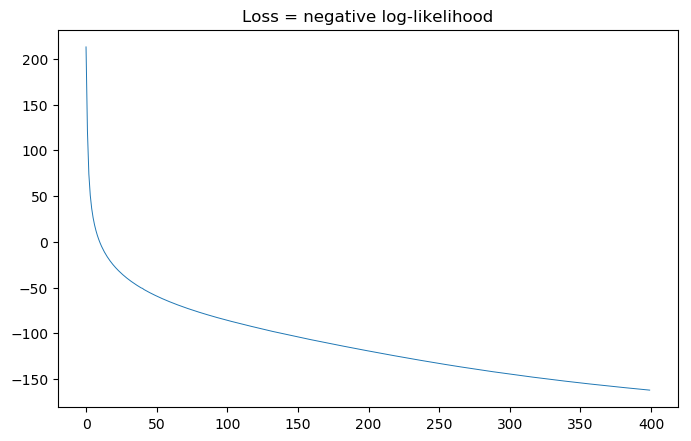

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
lineopts = {
    "linewidth": 0.7
}
ax.plot(range(train_size), loss_hist, **lineopts)
ax.set_title("Loss = negative log-likelihood")

In [246]:
import datetime

In [247]:
ts = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

In [248]:
flname = '{:}-{:}.pth'.format(nhlstm.__class__.__name__, ts)
print(flname)
fpath = '../saved_models/{:}'.format(flname)
print(fpath)

NeuralCTLSTM-20181106-011338.pth
../saved_models/NeuralCTLSTM-20181106-011338.pth


In [249]:
torch.save(nhlstm.state_dict(), fpath)

In [250]:
from models import EventGen

In [251]:
nhlstm.eval()
print(nhlstm.training)

False


In [252]:
neural_gen = EventGen(nhlstm)

In [253]:
neural_gen.generate_sequence(tmax)

Intens 7.175427436828613, lbdaMax 2.1992762088775635, s 0.7484055757522583
Intens 9.060787200927734, lbdaMax 4.074402332305908, s 0.9416638910770416
Intens 10.463441848754883, lbdaMax 5.480772495269775, s 1.1888689547777176
Intens 11.398139953613281, lbdaMax 6.413694381713867, s 1.4673691242933273
Intens 11.982505798339844, lbdaMax 6.9875922203063965, s 1.54518361389637
Intens 12.331347465515137, lbdaMax 7.32991886138916, s 1.5806150548160076
Intens 12.539957046508789, lbdaMax 7.5345916748046875, s 1.666279349476099
Intens 12.66795539855957, lbdaMax 7.662693023681641, s 1.8161349184811115
Intens 12.75108528137207, lbdaMax 7.744341850280762, s 1.8871796317398548
Intens 12.8020601272583, lbdaMax 7.797622203826904, s 2.1258980073034763
Intens 12.840827941894531, lbdaMax 7.833375453948975, s 2.1556990779936314
Intens 12.865372657775879, lbdaMax 7.857969760894775, s 2.191269289702177
Intens 12.88309097290039, lbdaMax 7.875255584716797, s 2.192252408945933
Intens 12.895315170288086, lbdaMax 

[0.0,
 0.7484055757522583,
 0.9416638910770416,
 1.1888689547777176,
 1.4673691242933273,
 1.54518361389637,
 1.5806150548160076,
 1.666279349476099,
 1.8161349184811115,
 1.8871796317398548,
 2.1258980073034763,
 2.1556990779936314,
 2.191269289702177,
 2.192252408945933,
 2.2062500456813723,
 2.3602401355747133,
 2.578165669227019,
 2.5983569885138422,
 2.748988669598475,
 2.848068896913901,
 2.8864583040121943,
 2.9411367292050272,
 3.060125824296847,
 3.0950264970306307,
 3.3315668592695147,
 3.492055151844397,
 3.639901269460097,
 3.7170908937696368,
 3.7223458650987595,
 3.847662216750905,
 3.909428297309205,
 3.9534902933519334,
 4.08641920122318,
 4.1632192123215646,
 4.1786634649615735,
 4.302949483273551,
 4.323286968050525,
 4.419654729543254,
 4.457200894830748,
 4.458953363355249,
 4.475266223307699,
 4.6935489675961435,
 4.808070582803339,
 4.8198604374192655,
 4.83794205961749,
 4.933346602600068,
 5.015530060511082,
 5.134360197465867,
 5.256385664921254,
 5.35407915292

In [254]:
neural_gen.hidden_hist

[{'hidden': tensor([[-0.1089, -0.1283, -0.1927, -0.3277,  0.1298,  0.1137, -0.2915, -0.1218]]),
  'cell': tensor([[-0.2094, -0.2173, -0.3111, -0.4825,  0.2777,  0.1879, -0.4239, -0.2096]]),
  'cell_target': tensor([[-0.2153, -0.2214, -0.3134, -0.3958,  0.2799,  0.1794, -0.2862, -0.2398]]),
  'cell_decay': tensor([[0.2762, 0.0495, 0.0353, 0.1597, 0.0275, 0.0264, 0.0226, 0.0509]]),
  'output': tensor([[0.5275, 0.5998, 0.6392, 0.7310, 0.4792, 0.6125, 0.7284, 0.5895]])},
 {'hidden': tensor([[-0.1829, -0.2863, -0.3865, -0.5563,  0.2428,  0.2675, -0.5371, -0.2190]]),
  'cell': tensor([[-0.3571, -0.4692, -0.6195, -0.8638,  0.4988,  0.4237, -0.8104, -0.3725]]),
  'cell_target': tensor([[-0.3513, -0.4452, -0.5920, -0.7012,  0.4885,  0.3913, -0.5110, -0.4271]]),
  'cell_decay': tensor([[0.2599, 0.0601, 0.0188, 0.1324, 0.0417, 0.0057, 0.0247, 0.0364]]),
  'output': tensor([[0.5336, 0.6544, 0.7017, 0.7968, 0.5265, 0.6687, 0.8018, 0.6149]])},
 {'hidden': tensor([[-0.2419, -0.4331, -0.5453, -0.7061,

In [270]:
def plot_intensity_for_seq():
    sequence = neural_gen.sequence_
    hidden_hist = neural_gen.hidden_hist
    tls = np.linspace(0, tmax, 100)[:-1]
    interv_counter = 0
    y_vals = np.zeros_like(tls)
    for i in range(len(tls)):
        t = tls[i]
        while t > sequence[interv_counter]:
            interv_counter += 1
        c_t = hidden_hist[interv_counter]['cell']
        c_target = hidden_hist[interv_counter]['cell_target']
        output = hidden_hist[interv_counter]['output']
        decay = hidden_hist[interv_counter]['cell_decay']
        hidden_t = output * torch.tanh(
            c_target + (c_t - c_target)*torch.exp(-decay*(t - sequence[interv_counter]))
        )
        with torch.no_grad():
            y_vals[i] = nhlstm.activation(nhlstm.w_alpha(hidden_t)).item()
    
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(tls, y_vals, linewidth=0.7)
    plt.scatter(sequence, y_vals.min()+ np.zeros_like(sequence), s=15, alpha=0.7)

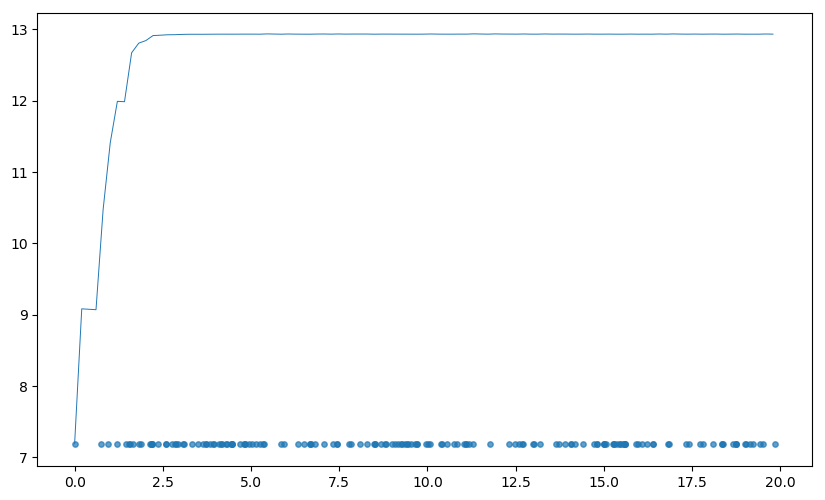

In [271]:
plot_intensity_for_seq()

In [149]:
x.dot(x)

tensor(4.5233)